In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm
import matplotlib.path as path
import matplotlib.patches as patches
from math import sqrt
from IPython.display import HTML
import matplotlib.animation as animation


import zero_d
import one_d
import two_d

np.random.seed(52500)

# Step 1. Naive simulation.
- Simulate N bodies
- There's a transmission rate 
- At each time step, all the infected people have some *transmission rate* probability of infecting everyone.
- Just tracking rate of *infection* through. Don't worry about death yet.
- 0 dimensional problem

In [5]:
%%time
df = zero_d.simulate(10000, .001, 30, 10)

100%|██████████| 29/29 [03:07<00:00,  6.45s/it]

CPU times: user 2min 53s, sys: 2.65 s, total: 2min 56s
Wall time: 3min 7s


Text(0, 0.5, 'Number of infected individuals')

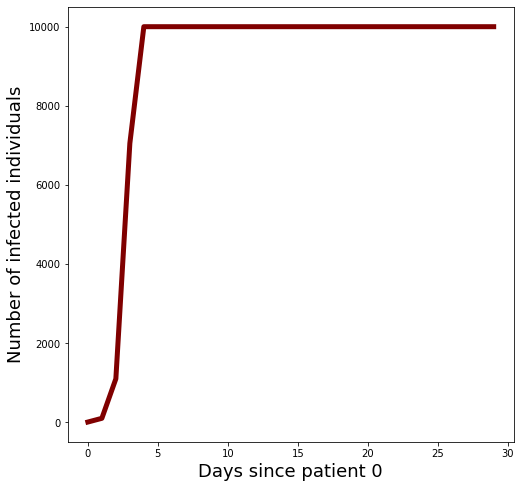

In [6]:
plt.figure(figsize=(8,8))
infections = np.array([df[col].sum() for col in df.columns if 'infected day' in col])
plt.plot(np.arange(len(infections)), 10000 - infections, lw=5, color='maroon')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
# plt.xscale('log')
# plt.yscale('log')

# Step 2. 1D simulation
- Same as before, but now accounting for *distance* between people
- a distance factor, within some certain range, is multiplied to base transmission factor
- randomly initialize the N bodies around the origin

In [2]:
# df1D = simulate1D(100000, .1, 30, 1, 2, 3, np.random.uniform, low=-10, high=10)
df1D = one_d.simulate1D(10000, .001, 30, 10, 1., 3, np.random.uniform, np.random.normal, kwargs_for_pop={'low':-20, 'high':20}, kwargs_for_infec={'loc': 1, 'scale': .1})

# it's likely that the distance metric needs to be suppressed even more, not transmission!

100%|██████████| 29/29 [16:04<00:00, 33.27s/it]


Text(0.5, 1.0, 'Spread of disease: N = 100,000 individuals')

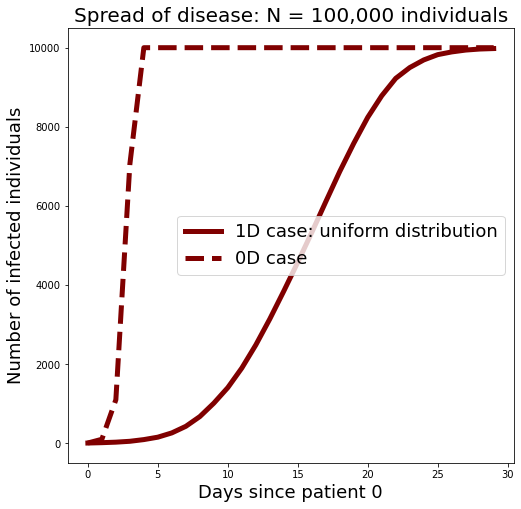

In [7]:
plt.figure(figsize=(8,8))
infections1D = np.array([df1D[col].sum() for col in df1D.columns if 'infected day' in col])
plt.plot(np.arange(len(infections1D)), 10000 - infections1D, lw=5, color='maroon', 
         linestyle='-', label='1D case: uniform distribution')
plt.plot(np.arange(len(infections)), 10000 - infections, lw=5, color='maroon',
        linestyle='--', label='0D case')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
plt.legend(fontsize=18)
plt.title('Spread of disease: N = 100,000 individuals', fontsize=20)
# plt.xscale('log')
# plt.yscale('log')

## Animate histograms of each day

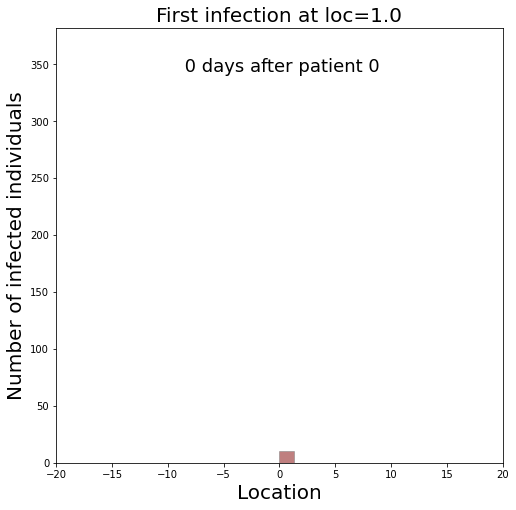

In [14]:
ani = one_d.animate_histogram(df1D, 'First infection at loc=1.0')

In [17]:
HTML(ani.to_html5_video())

# Step 3. 2D simulation
- mostly same idea as 1D. 
- modify the metric
- change locs to x
- add a y column
- initialize with 2d distributions

In [22]:
df2D = two_d.simulate2D(1000000, .001, 22, 10, 1., 3, np.random.uniform, np.random.normal, 
                  kwargs_for_pop={'low':25, 'high':45}, 
                  kwargs_for_infec={'loc': 30, 'scale': 2})

100%|██████████| 21/21 [03:53<00:00, 11.10s/it]


Text(0.5, 1.0, 'Spread of disease: N = 100,000 individuals')

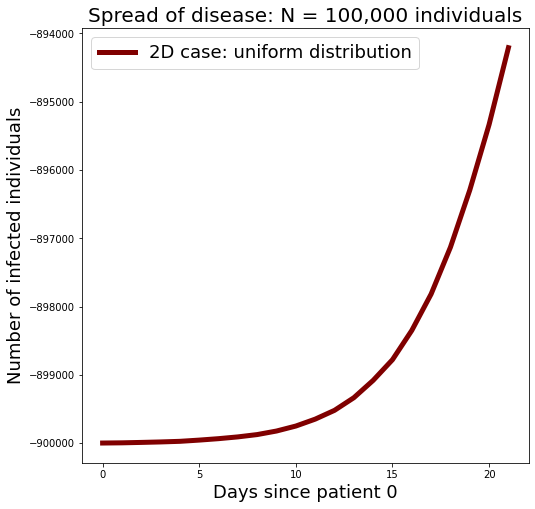

In [23]:
plt.figure(figsize=(8,8))
infections2D = np.array([df2D[col].sum() for col in df2D.columns if 'infected day' in col])
plt.plot(np.arange(len(infections2D)), 100000 - infections2D, lw=5, color='maroon', 
         linestyle='-', label='2D case: uniform distribution')
plt.xlabel('Days since patient 0', fontsize=18)
plt.ylabel('Number of infected individuals', fontsize=18)
plt.legend(fontsize=18)
plt.title('Spread of disease: N = 100,000 individuals', fontsize=20)

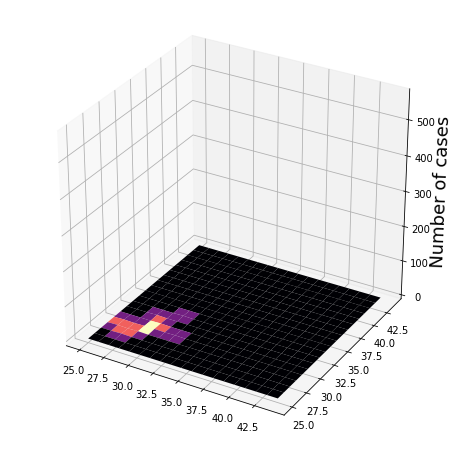

In [27]:
infected = df2D[df2D['infected day 21'] == 0]
H1, xedges, yedges = np.histogram2d(infected['x'], infected['y'], 
                                   bins=(np.linspace(25, 45, 20), np.linspace(25, 45, 20)))
infect_cols = [col for col in df2D.columns if 'infected day' in col]
def animate(i, plot):
    # simulate new data coming in
    ax.clear()
    infect_col = infect_cols[i]
    infected = df2D[df2D[infect_col] == 0]
    H, xedges, yedges = np.histogram2d(infected['x'], infected['y'], 
                                   bins=(np.linspace(25, 45, 20), np.linspace(25, 45, 20)))
    plot = ax.plot_surface(X, Y, H, cmap='magma')
#     ax.set_zlim(0,np.max(H))
    ax.set_zlim(0, np.max(H1))
    ax.set_zlabel('Number of cases', fontsize=18)

    return plot,


X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
plot = [ax.plot_surface(X, Y, H1, cmap='magma')]
ax.set_zlim(0, np.max(H1))
ax.set_zlabel('Number of cases', fontsize=18)
# ax.set_xlim(left[0], right[-1])
# ax.set_ylim(bottom.min(), top.max())

ani = animation.FuncAnimation(fig, animate, len(infect_cols), fargs=(plot), repeat=False, blit=True)

In [ ]:
HTML(ani.to_html5_video())

# Step 4. Input a map to our model (incomplete)

In [ ]:
@jit(nopython=True)
def find_first(searched, vec):
    """return the index of the first occurence of item in vec"""
    for i, item in enumerate(vec):
        if searched == item:
            return i
    return -1

def do_multiplier(x, y, power, thresh, df_sorted, df2D_test, farthest_calc):
    x = np.float64(x)
    y = np.float64(y)
    power = np.float64(power)
    thresh = np.float64(thresh)
    place_in_sorted = find_first(x, df_sorted.x.values)
    calc_indices = df_sorted.index[place_in_sorted 
                                   - np.int(farthest_calc):place_in_sorted 
                                   + np.int(farthest_calc)]
    df_calc_x = df2D_test.x[calc_indices]
    df_calc_y = df2D_test.y[calc_indices]
    dists = np.sqrt((df_calc_x.sub(x))**2 + (df_calc_y.sub(y))**2)
    multiplier_col = np.where(dists > thresh, np.power(dists, -power), np.ones_like(dists))
    return multiplier_col, calc_indices

def distance(frame, ind1, ind2):
    """Just finding the distance between two rows and their x-y pairs."""
    lat1, long1 = frame['lat'].values[ind1], frame['long'].values[ind1]
    lat2, long2 = frame['lat'].values[ind2], frame['long'].values[ind2]
    return geopy.distance.geodesic((lat1, long2), (lat2, long2)).km

In [41]:
def infect2D(df, trans_rate, day_name, thresh, power, df_sorted, farthest_calc):
    """
    Simulates a single day of infection in 1D. 
    
    NOTE: a 0 counts as infected, while a 1 is healthy.
    
    Inputs:
        df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        day_name : (float or int) the day of this infection, used to create a new
                        column in the dataframe tracking the day's infections.
        dist_matrix : (numpy.ndarray) distance matrix holding the distances between all individuals.
                        
    Outputs:
        df : (pandas DataFrame) object, same as the input, but with a new column
                        holding this day's infected results.
    """
    df[f"infected day {day_name}"] = df[f"infected day {day_name - 1}"].copy()
    infected = df[df[f'infected day {day_name}'] == 0.]
    
    if len(infected) == len(df): # everyone is infected
        return df
    for i in range(len(infected)): # this is number of rows, right?  
        # find distance multiplier between this ind and all others
        x, y = infected['x'].values[i], infected['y'].values[i]
        multiplier_col, calc_indices = do_multiplier(x, y, power, thresh, df_sorted, df, farthest_calc)
        p = 1 - (multiplier_col * trans_rate)
        infect_col = np.random.binomial(size=len(calc_indices), p=p, n=1) # 1 toss
        df.loc[calc_indices, f'infected day {day_name}'] *= infect_col
    return df


In [42]:
def simulate2D(N, trans_rate, t_steps, N_initial, thresh, power, 
               distrib_pop, distrib_infec, kwargs_for_pop={}, 
               kwargs_for_infec={}, dist_matrix=None):
    """
    Simulates an infection run in 1D.
    
    Inputs:
        N : (int) number of individuals in the system.
        trans_rate : (float) rate of transmission between individuals. infection
                        is performed in a probabilistic manner, casting it as a 
                        draw from a binomial distribution with a rate of 
                        1 - trans_rate.
        t_steps : (int) number of time steps ("days") to consider.
        N_initial : (int) number of initially infected individuals.
        thresh : (float) distance less than which infection is transmitted at the trans_rate;
                            that is, less than which this function returns a value of 1. At
                            a distance greater than this, this function returns 1/distance^power.
        power : (float) Greater than 0. Power to which the multiplier falls off if the distance
                            is greater than some threshold.
        distrib_pop : (func) distribution function to determine how individuals are initialized.
        distrib_infec : (func) distribution function to determine how initial infections are initialized.
        kwargs_for_pop : (dict) keyword arguments passed to the distrib_pop distribution type. 
                        Size not included.
        kwargs_for_infec : (dict) keyword arguments passed to the distrib_infect distribution type. Size not 
                        included.
        
    Outputs:
         df : (pandas DataFrame) object holding all values of infected people. Each
                        column of "infected day _" corresponds to a different day, 
                        with "_" being some integer or float. The "name" column
                        assigns a name to each object, independent of index. In
                        the infected columns, a 0 counts as infected, while a 1 is 
                        healthy. 
    """
    # making separate name column because indices get messy. 
    # other cols later.
    name = np.arange(N)
    zero_infected = np.ones(N)
    pop = initialize_pop_2D(N, distrib_pop, **kwargs_for_pop)
    x, y = pop[:, 0], pop[:, 1]
    d = {'name': np.arange(N), 'infected day 0': zero_infected, 'x' : x, 'y' : y} 

    df = pd.DataFrame(data=d)
    
    
    pop = initialize_pop_2D(N_initial, distrib_infec, **kwargs_for_infec)
    x, y = pop[:, 0], pop[:, 1]
    all_infected = np.zeros(N_initial)
    d_infec = {'name': np.arange(N, N + N_initial), 'infected day 0': all_infected, 'x' : x, 'y' : y}
    df_infec = pd.DataFrame(data=d_infec)
    
    df = df.append(df_infec, ignore_index = True)
    
    test_vals = np.round(np.linspace(1, 1000, 100))
    df['Rank'] = df.x.rank() + df.y.rank()
    df_sorted = df.sort_values('Rank', ascending=False).drop('Rank',axis=1)
    dists = np.array([distance(df_sorted, 100, int(val)) for val in test_vals])
    farthest_calc = int(test_vals[np.argmin(np.abs(dists - thresh))])
    # the above determines the farthest index to calculate distance from a given point.
    
    for t in tqdm(range(1, t_steps), position=0, leave=True):
        df = infect2D(df, trans_rate, t, thresh, power, df_sorted, farthest_calc)
    return df

In [93]:
def initialize_pop_2D(N=100, distrib=np.random.uniform, input_map=None, **kwargs):
    '''
    This will change once we have the U.S. map.
    
    distrib: size is not a thing again.
    '''
    if not np.any(input_map):
        pop = distrib(size=(N, 2), **kwargs)
    else:
        lats = []
        longs = []
        ipdb.set_trace()
        for index, row in input_map.iterrows():
            lat = row['latitude']
            long = row['longitude']
            
            for i in range(row['estimated_population']):
                lats.append(lat)
                longs.append(long)
        pop = [lat, long]
    return pop

In [74]:
covid_county=pd.read_csv('us-counties.csv',  encoding='latin-1')
covid_county_sorted = covid_county.sort_values(by=['state', 'county', 'date'])
county= pd.read_csv('with_Counties.csv',  encoding='latin-1')
county_sorted= county.sort_values(by=['state', 'county', 'primary_city'])
covid_county_location=pd.merge(
    covid_county_sorted, county_sorted[['latitude', 'longitude', 'county', 'estimated_population']], on='county')

In [75]:
NY = covid_county_location[covid_county_location['state'] == 'New York']

In [81]:
NY['estimated_population'].values

array([ 689, 4065, 3395, ...,    0,    0,    0])

In [94]:
initialize_pop_2D(input_map=NY)

> <ipython-input-93-3034cefbb6c3>(13)initialize_pop_2D()
     12         ipdb.set_trace()
---> 13         for index, row in input_map.iterrows():
     14             lat = row['latitude']

ipdb> c


[37.58, -81.58]